# exp 8 뉴스 요약봇 만들기
## 작업파일 링크 :&nbsp;&nbsp;

### 평가기준
### 1. Abstractive 모델 구성을 위한 텍스트 전처리 단계가 체계적으로 진행되었다.

분석단계, 정제단계, 정규화와 불용어 제거, 데이터셋 분리, 인코딩 과정이 빠짐없이 체계적으로 진행되었다.
#### 2. 텍스트 요약모델이 성공적으로 학습되었음을 확인하였다.

모델학습이 안정적으로 수렴되었음을 그래프를 통해 확인하였으며, 실제 요약문과 유사한 요약문장을 얻을 수 있었다.
#### 3. Extractive 요약을 시도해 보고 Abstractive 요약 결과과 함께 비교해 보았다.

두 요약 결과를 문법완성도 측면과 핵심단어 포함 측면으로 나누어 비교분석 결과를 제시하였다.

***
## 긴 문장을 짧게 요약해 주는 텍스트 요약기를 만들기.

***
### 1. 데이터 준비하기

In [1]:
import nltk
nltk.download('stopwords')

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

print("☢️")

[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


☢️


In [2]:
data = pd.read_csv(os.getenv("HOME")+"/aiffel/news_summarization/data/Reviews.csv", nrows=100000)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 100000


In [3]:
data.head()

# 전체 데이터 중 Summary 열과 Text 열만 훈련에 사용할 거라, 이 두 개의 열만 별도로 저장
data = data[['Text','Summary']]
data.head()

#랜덤한 15개 샘플 출력
data.sample(5)

,Text,Summary
84816,I have been getting the Coffee People Extra Bo...,Need to brew small cup size. Check the price!
12284,These had been my dog's favorite treats. BUT w...,Vet says NO
12271,I bought these from a large chain pet store. a...,do not buy
88202,I have a one and two year old who just love th...,My kids love these
55583,What a delicious breakfast cereal! These aren'...,Mighty Tasty


***
### 2. 데이터 전처리 하기 - (1) 데이터 정리하기
빈칸으로 존재하는 null 데이터, 
의미는 같지만 다른 식으로 작성된 글 같은 중복 항목과 같은 학습할 때 방해가 되는 데이터 정리하기.

***
#### ⦿ 중복 샘플과 NULL 값이 존재하는 샘플 제거

In [4]:
print('Text 열에서 중복을 배제한 유일한 샘플의 수 :', data['Text'].nunique())
print('Summary 열에서 중복을 배제한 유일한 샘플의 수 :', data['Summary'].nunique())

Text 열에서 중복을 배제한 유일한 샘플의 수 : 88426
Summary 열에서 중복을 배제한 유일한 샘플의 수 : 72348


In [5]:
# 데이터프레임의 drop_duplicates()를 사용하면, 손쉽게 중복 샘플을 제거

# inplace=True 를 설정하면 DataFrame 타입 값을 return 하지 않고 data 내부를 직접적으로 바꿉니다
data.drop_duplicates(subset = ['Text'], inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 88426


In [6]:
# 데이터프레임에 Null 값이 있는지 확인하는 방법은 .isnull().sum()을 사용

print(data.isnull().sum())

Text       0
Summary    1
dtype: int64


In [7]:
# 데이터프레임에서 Null을 제거할 때는 dropna() 함수를 사용

data.dropna(axis=0, inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 88425


#### ⦿ 텍스트 정규화와 불용어 제거

In [8]:
# 단어들 중에서는 같은 의미인데도 다른 표현으로 쓰여 마치 다른 단어들처럼 간주되는 경우가 있음.
# 예) it'll은 it will과 같고, mustn't과 must not은 사실 같은 표현임.
# 기계 학습 전에 미리 같은 표현으로 통일시켜주는 것이 기계의 연산량을 줄일 수 있는 방법임.
# 이러한 방법론을 텍스트 처리에서는 텍스트 정규화(text normalization) 라고 한다. 

contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


In [9]:
# 일반적으로 텍스트에는 자주 등장하지만 자연어 처리를 할 때 실질적으로 별 도움이 되지 않는 단어들이 존재. 
# 이를 불용어(stopwords)라함. 때로는 불용어를 제거하는 것이 자연어 처리의 성능을 높이는 방법일 수 있. 
# 여기서는 NLTK에서 제공하는 불용어 리스트를 참조해, 샘플에서 불용어를 제거

print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

In [10]:
# NLTK를 이용하여 불용어를 제거, 
# 모든 영어 문자는 소문자로 만들고, 
# 섞여있는 html 태그를 제거하고, 
# 정규 표현식을 통해 각종 특수문자를 제거한다.

# NLTK를 이용 불용어 제거는 Text 전처리 시에서만 함. 상대적으로 문장 길이가 짧은 Summary 전처리시에는 호출하지 않. 
# Abstractive한 문장 요약의 결과문이 자연스러운 문장이 되려면 불용어들이 Summary에는 남아 있는 게 더 좋을 것 같음. 
# 이 처리를 위해서 함수의 인자로 remove_stopwords를 추가 

# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower()                # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence)   # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence)             # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens
print('☢️')

☢️


In [11]:
# preprocess_sentence() 테스트 

temp_text = 'Everything I bought was great, infact I ordered twice and the third ordered was<br />for my mother and father.'
temp_summary = 'Great way to start (or finish) the day!!!'

print("text\t:", temp_text)
print("text\t:", preprocess_sentence(temp_text))
print("summary\t:", temp_summary)
print("summary\t:", preprocess_sentence(temp_summary, False))  # 불용어를 제거하지 않습니다.

text	: Everything I bought was great, infact I ordered twice and the third ordered was<br />for my mother and father.
text	: everything bought great infact ordered twice third ordered wasfor mother father
summary	: Great way to start (or finish) the day!!!
summary	: great way to start the day


In [12]:
# 훈련 데이터(text부분) 전체에 대하여 전처리 수행 시작
    
clean_text = []
# 전체 Text 데이터에 대한 전처리 : 10분 이상 시간이 걸릴 수 있습니다. 
for s in data['Text']:
    clean_text.append(preprocess_sentence(s))

# 전처리 후 출력
print("Text 전처리 후 결과: ", clean_text[:5])

Text 전처리 후 결과:  ['bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better', 'product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo', 'confection around centuries light pillowy citrus gelatin nuts case filberts cut tiny squares liberally coated powdered sugar tiny mouthful heaven chewy flavorful highly recommend yummy treat familiar story lewis lion witch wardrobe treat seduces edmund selling brother sisters witch', 'looking secret ingredient robitussin believe found got addition root beer extract ordered made cherry soda flavor medicinal', 'great taffy great price wide assortment yummy taffy delivery quick taffy lover deal']


In [13]:
# 훈련 데이터(summary부분) 전체에 대하여 전처리 수행 시작

clean_summary = []
# 전체 Summary 데이터에 대한 전처리 : 5분 이상 시간이 걸릴 수 있습니다. 
for s in data['Summary']:
    clean_summary.append(preprocess_sentence(s, False))

print("Summary 전처리 후 결과: ", clean_summary[:5])

Summary 전처리 후 결과:  ['good quality dog food', 'not as advertised', 'delight says it all', 'cough medicine', 'great taffy']


In [14]:
# 전처리 후 다시한번 데이터 상태 확인 필요
# 빈(empty) 샘플이 생겼는지 확인
# 보다 쉽게 확인하기 위해 데이터들을 데이터프레임에 재저장. 빈(empty) 값을 가진 샘플들이 있다면, 모두 Null 값을 가진 샘플로 대체.

data['Text'] = clean_text
data['Summary'] = clean_summary

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)
print('☢️')

☢️


In [15]:
# null 확인 

data.isnull().sum()

Text        0
Summary    70
dtype: int64

In [16]:
# Summary 열에서 70개의 Null 발생. 
# null이 발생한 샘플들은 모두 제거.

data.dropna(axis=0, inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 88355


***
### 3. 데이터 전처리하기 - (2) 훈련데이터와 테스트데이터 나누기
학습을 진행하기 위해서는 학습에 사용할 데이터의 크기를 결정하고, 문장의 시작과 끝을 표시해 주어야 함.

### ⦿ 샘플의 최대 길이 정하기

텍스트의 최소 길이	: 2
텍스트의 최대 길이	: 1235
텍스트의 평균 길이	: 38.792428272310566
요약의 최소 길이	: 1
요약의 최대 길이	: 28
요약의 평균 길이	: 4.010729443721352


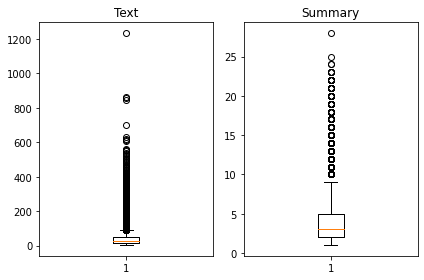

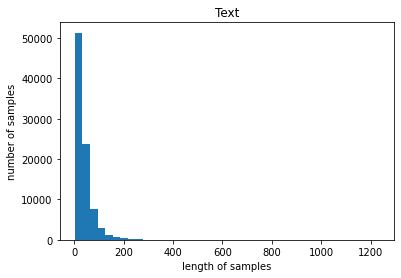

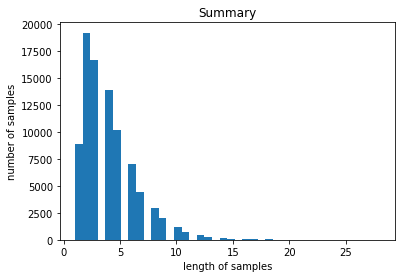

In [17]:
# Text와 Summary의 최소, 최대, 평균 길이를 구하고 또한 길이 분포를 시각화
# 길이 분포 출력

import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['Text']]
summary_len = [len(s.split()) for s in data['Summary']]

print('텍스트의 최소 길이\t: {}'.format(np.min(text_len)))
print('텍스트의 최대 길이\t: {}'.format(np.max(text_len)))
print('텍스트의 평균 길이\t: {}'.format(np.mean(text_len)))
print('요약의 최소 길이\t: {}'.format(np.min(summary_len)))
print('요약의 최대 길이\t: {}'.format(np.max(summary_len)))
print('요약의 평균 길이\t: {}'.format(np.mean(summary_len)))

plt.subplot(1,2,1)       # 1X2의 1번째에 그린다.
plt.boxplot(text_len)
plt.title('Text')
plt.subplot(1,2,2)       # 1X2의 2번째에 그린다.
plt.boxplot(summary_len) # 평균, 최솟값, 최댓값을 보여준다,.
plt.title('Summary')
plt.tight_layout()       # 자동으로 subplot간의 간격을 조절 한다. 
plt.show()

plt.title('Text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('Summary')
plt.hist(summary_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [18]:
#  Text의 최대 길이와 Summary의 적절한 최대 길이를 임의로 정함

text_max_len = 50
summary_max_len = 8
print('=3')

=3


In [19]:
# 훈련 데이터와 샘플의 길이를 입력하면, 데이터의 몇 %가 해당하는지 계산하는 함수

def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율 : %s'%(max_len, (cnt / len(nested_list))))
print('=3')

=3


In [20]:
below_threshold_len(text_max_len, data['Text'])
below_threshold_len(summary_max_len,  data['Summary'])

전체 샘플 중 길이가 50 이하인 샘플의 비율 : 0.7745119121724859
전체 샘플 중 길이가 8 이하인 샘플의 비율 : 0.9424593967517402


In [21]:
# 정해진 길이보다 길면 제외하는 방법으로 데이터를 정제

data = data[data['Text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['Summary'].apply(lambda x: len(x.split()) <= summary_max_len)]
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 65818


### ⦿ 시작 토큰과 종료 토큰 추가하기

In [22]:
# 요약 데이터에는 시작 토큰과 종료 토큰을 추가한다.
# sostoken : 시작 토큰
# eostoken : 종료 토큰 
# decoder_input  : 디코더의 입력에 해당하면서 시작 토큰이 맨 앞에 있는 문장의 이름
# decoder_target : 디코더의 출력 또는 레이블에 해당되면서 종료 토큰이 맨 뒤에 붙는 문장의 이름 

data['decoder_input'] = data['Summary'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['Summary'].apply(lambda x : x + ' eostoken')
data.head()

,Text,Summary,decoder_input,decoder_target
0,bought several vitality canned dog food produc...,good quality dog food,sostoken good quality dog food,good quality dog food eostoken
1,product arrived labeled jumbo salted peanuts p...,not as advertised,sostoken not as advertised,not as advertised eostoken
2,confection around centuries light pillowy citr...,delight says it all,sostoken delight says it all,delight says it all eostoken
3,looking secret ingredient robitussin believe f...,cough medicine,sostoken cough medicine,cough medicine eostoken
4,great taffy great price wide assortment yummy ...,great taffy,sostoken great taffy,great taffy eostoken


In [23]:
# 인코더의 입력, 디코더의 입력, 디코더의 레이블을 각각 Numpy 타입으로 저장(지정)
    
encoder_input = np.array(data['Text'])            # 인코더의 입력
decoder_input = np.array(data['decoder_input'])   # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블
print('=3')

=3


In [24]:
# 훈련 데이터와 테스트 데이터를 분리하는 코딩을 직접 작성

indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

# 위에서 만든 정수 시퀀스를 이용해 다시 데이터의 샘플 순서를 정의해 주면 잘 섞인 샘플이 
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]
print('=3')

[36344 19121 56452 ... 56636 42882 63688]
=3


In [25]:
# 테스트 데이터의 수를 20%로 정하고 해당 수를 구한다. 

n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 13163


In [26]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 52655
훈련 레이블의 개수 : 52655
테스트 데이터의 개수 : 13163
테스트 레이블의 개수 : 13163


***
### 4. 데이터 전처리하기 - (3) 정수 인코딩
이제 기계가 텍스트를 숫자로 처리할 수 있도록 훈련 데이터와 테스트 데이터의 단어들을 모두 정수로 바꾸어 주어야 해요

### ⦿ 단어 집합(vocabulary) 만들기 및 정수 인코딩

In [27]:
# Keras의 토크나이저를 사용하면, 입력된 훈련 데이터로부터 단어 집합을 만들 수 있어요.

src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성
print('=3')

=3


In [28]:
# 단어 집합에 있는 모든 단어를 사용하는 것이 아니라, 빈도수가 낮은 단어들은 훈련 데이터에서 제외하고 진행
# src_tokenizer.word_counts.items()에는 단어와 각 단어의 등장 빈도수가 저장

threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기      :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수 : %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 : %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율           :", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율 :", (rare_freq / total_freq)*100)


# 등장 빈도가 threshold 값인 7회 미만, 즉 6회 이하인 단어들은 단어 집합에서 무려 70% 이상을 차지하네요. 
# 하지만 실제로 훈련 데이터에서 등장 빈도로 차지하는 비중은 상대적으로 적은 수치인 3.39%밖에 되지 않아요.

단어 집합(vocabulary)의 크기      : 31876
등장 빈도가 6번 이하인 희귀 단어의 수 : 23619
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 : 8257
단어 집합에서 희귀 단어의 비율           : 74.09649893336679
전체 등장 빈도에서 희귀 단어 등장 빈도 비율 : 3.3670036319850785


In [29]:
# 등장 빈도가 6회 이하인 단어들은 정수 인코딩 과정에서 빼고, 훈련 데이터에서 제거

src_vocab = 8000
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 8,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성
print('=3')

=3


In [30]:
# texts_to_sequences()는 생성된 단어 집합에 기반하여 입력으로 주어진 텍스트 데이터의 단어들을 모두 정수로 변환하는 정수 인코딩을 수행

# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[48, 3201, 7207, 736, 409, 316, 128, 4084, 3, 117, 598, 3468, 17, 414, 234, 3307, 731, 5095, 322], [1002, 262, 209, 5269, 3584, 122, 100, 680, 607, 123, 2192, 1243, 2065, 1607, 149, 3585, 3586, 6185, 533, 37, 149, 84, 262, 3, 16, 1, 274, 262, 25, 17, 453, 303, 1631], [91, 152, 52, 5, 366, 1555, 152, 78, 1409, 26, 164, 395, 1005]]


In [31]:
# Summary 데이터에 대해서도 동일한 작업을 수행
# 케라스의 토크나이저를 사용하여 decoder_input_train을 입력으로 전체 단어 집합과 각 단어에 대한 빈도수를 계산
    
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)
print('=3')

=3


### ⦿ 중간 점검 
- 이제 단어 집합이 생성되는 동시에 각 단어에 고유한 정수가 부여되, tar_tokenizer.word_index에 저장되어 있어요
- tar_tokenizer.word_counts.items()에는 단어와 각 단어의 등장 빈도수가 저장

In [32]:
# 등장 빈도수가 6회 미만인 단어들이 이 데이터에서 얼만큼의 비중을 차지하는지 확인

threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)


# 등장 빈도가 5회 이하인 단어들은 단어 집합에서 약 77%를 차지하고 있네요. 
# 하지만 실제로 훈련 데이터에서 등장 빈도로 차지하는 비중은 상대적으로 매우 적은 수치인 5.87%밖에 되지 않아요

단어 집합(vocabulary)의 크기 : 10441
등장 빈도가 5번 이하인 희귀 단어의 수: 8053
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 2388
단어 집합에서 희귀 단어의 비율: 77.12862752609904
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 5.844530328722552


In [33]:
# 등장 빈도가 5회 이하인 단어들은 정수 인코딩 과정에서 빼고, 훈련 데이터에서 제거

tar_vocab = 2000
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train)
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 24, 60, 8, 268, 10], [1, 1797, 203], [1, 80, 53, 656], [1, 4, 17], [1, 502, 697, 235]]
target
decoder  [[24, 60, 8, 268, 10, 2], [1797, 203, 2], [80, 53, 656, 2], [4, 17, 2], [502, 697, 235, 2]]


### ⦿ 잠깐만 
전체 데이터에서 빈도수가 낮은 단어가 삭제되었다는 것은 빈도수가 낮은 단어만으로 구성되었던 샘플들은 이제 빈(empty) 샘플이 되었을 가능성이 있어요
평균 길이가 4밖에 되지 않았던 요약문(Summary)의 경우에는 이 현상이 굉장히 두드러졌을 가능성이 높겠죠.
요약문인 decoder_input에는 sostoken 또는 decoder_target에는 eostoken이 추가된 상태이고, 
이 두 토큰은 모든 샘플에서 등장하므로 빈도수가 샘플 수와 동일하게 매우 높으므로 단어 집합 제한에도 삭제되지 않았어요. 
그래서 이제 길이가 0이 된 요약문의 실제 길이는 1로 나올 것임.
길이 0이 된 decoder_input에는 sostoken, decoder_target에는 eostoken만 남아 있을 테니까요.    

In [34]:
# 훈련 데이터와 테스트 데이터에 대해서 요약문의 길이가 1인 경우의 인덱스를 각각 drop_train과 drop_test에 라는 변수에 저장
# 이 샘플들은 모두 삭제할 것임.

drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 1238
삭제할 테스트 데이터의 개수 : 363
훈련 데이터의 개수 : 51417
훈련 레이블의 개수 : 51417
테스트 데이터의 개수 : 12800
테스트 레이블의 개수 : 12800


### ⦿ 패딩하기
텍스트 시퀀스를 정수 시퀀스로 변환했다면, 이제 서로 다른 길이의 샘플들을 병렬 처리하기 위해 같은 길이로 맞춰주는 패딩 작업필요<br>최대 길이에 맞도록 최대 길이보다 짧은 데이터들은 뒤의 공간에 숫자 0을 넣어 최대 길이로 길이를 맞춤

In [35]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=summary_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=summary_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=summary_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=summary_max_len, padding='post')
print('=3')

=3


### ⦿ 데이터 전처리 완료 !!!!!!!

### 5. 모델 설계하기 (인코더 + 디코더)

In [36]:
# 함수형 API를 이용해서 인코더를 설계
    
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256   # hidden state는 LSTM에서 얼만큼의 수용력(capacity)를 가질지를 정하는 파라미터
                    # 이 파라미터는 LSTM의 용량의 크기나, LSTM에서의 뉴런의 개수라 이해하자.

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, 
                     return_sequences=True, 
                     return_state=True ,
                     dropout = 0.4,           # dropout은 레이어의 weight를 랜덤으로 생략하여 모델의 과적합(overfitting)을 해결해주는 방법
                     recurrent_dropout = 0.4) # recurrent dropout은 dropout을 레이어가 아닌 time step마다 해주는 방식
                                              # ,즉 time step의 입력을 랜덤으로 생략해 주는 효과가 있음.
                                              # recurrent dropout은 일반적인 dropout와 같이 regularization을 해주는 효과가 있고, 
                                              # 과적합을 방지할 수 있다고 해요
                                              # dropout과 recurrent dropout을 모두 사용한 것을 Variational Dropout이라 함.
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

In [37]:
# 디코더 설계
# 디코더 설계시 LSTM의 입력을 정의할 때, 
# initial_state의 인자값으로 인코더의 hidden state와 cell state의 값을 넣어줘야 해요

decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

In [38]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 50, 128)      1024000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 50, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

⦿ 지금까지 설계한 것은 인코더의 hidden state와 cell state를 디코더의 초기 state로 사용하는 가장 기본적인 seq2seq<br>
⦿ 디코더의 출력층을 설계를 살짝 바꿔서 성능을 높일 수 있는 방법 => 어텐션 메커니즘이에요.

### ⦿ 어텐션 메커니즘
어텐션 메커니즘을 수행하는 어텐션 함수를 설계하는 것은 또 다른 새로운 신경망을 설계해야 한다는 뜻<br>
여기서 사용하는 어텐션 함수는 Bahdanau 스타일의 어텐션입니다    

In [39]:
from tensorflow.keras.layers import AdditiveAttention

# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])


# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()


# 인코더의 hidden state들과 디코더의 hidden state들을 어텐션 함수의 입력으로 사용하고, 
# 어텐션 함수가 리턴한 값을 예측 시에 디코더의 hidden state와 함께 활용하는 형태로 작동

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 50, 128)      1024000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 50, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

### 6. 모델 훈련 하기

In [40]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

# '조기 종료'를 뜻하는 EarlyStopping은 특정 조건이 충족되면 훈련을 멈추는 역할
# 아래 코드에서는 val_loss(검증 데이터의 손실)을 관찰하다가, 
# 검증 데이터의 손실이 줄어들지 않고 증가하는 현상이 2회(patience=2) 관측되면 학습을 멈추도록 설정됨
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)

history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
                    validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
                    batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
201/201 [==============================] - 147s 648ms/step - loss: 2.7019 - val_loss: 2.4059
Epoch 2/50
201/201 [==============================] - 129s 640ms/step - loss: 2.3681 - val_loss: 2.2557
Epoch 3/50
201/201 [==============================] - 128s 639ms/step - loss: 2.2166 - val_loss: 2.1453
Epoch 4/50
201/201 [==============================] - 128s 639ms/step - loss: 2.1060 - val_loss: 2.0590
Epoch 5/50
201/201 [==============================] - 128s 639ms/step - loss: 2.0206 - val_loss: 2.0019
Epoch 6/50
201/201 [==============================] - 129s 640ms/step - loss: 1.9554 - val_loss: 1.9610
Epoch 7/50
201/201 [==============================] - 128s 639ms/step - loss: 1.9030 - val_loss: 1.9392
Epoch 8/50
201/201 [==============================] - 128s 637ms/step - loss: 1.8593 - val_loss: 1.9153
Epoch 9/50
201/201 [==============================] - 128s 637ms/step - loss: 1.8214 - val_loss: 1.9002
Epoch 10/50
201/201 [==============================] - 129s 640m